### Marketing A/B testing dataset
Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

#### The companies are interested in answering two questions:

Would the campaign be successful?
If the campaign was successful, how much of that success could be attributed to the ads?
With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

### Data dictionary:

Index: Row index
user id: User ID (unique)
test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
converted: If a person bought the product then True, else is False
total ads: Amount of ads seen by person
most ads day: Day that the person saw the biggest amount of ads
most ads hour: Hour of day that the person saw the biggest amount of ads

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marketing-ab-testing/marketing_AB.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
sns.set()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('/kaggle/input/marketing-ab-testing/marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.describe(include='all')

,user id,test group,converted,total ads,most ads day,most ads hour
count,5.881010e+05,588101,588101,588101.000000,588101,588101.000000
unique,NaN,2,2,NaN,7,NaN
top,NaN,ad,False,NaN,Friday,NaN
freq,NaN,564577,573258,NaN,92608,NaN
mean,1.310692e+06,NaN,NaN,24.820876,NaN,14.469061
std,2.022260e+05,NaN,NaN,43.715181,NaN,4.834634
min,9.000000e+05,NaN,NaN,1.000000,NaN,0.000000
25%,1.143190e+06,NaN,NaN,4.000000,NaN,11.000000
50%,1.313725e+06,NaN,NaN,13.000000,NaN,14.000000
75%,1.484088e+06,NaN,NaN,27.000000,NaN,18.000000


In [5]:
# clean the column names
df.columns = np.array(pd.Series(df.columns).apply(lambda x: x.replace(' ', '_')))

In [6]:
df.isnull().sum()

user_id          0
test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64

**split the data into ad and psa**

In [7]:
ad = df[df.test_group == 'ad'].reset_index(drop=True)
psa = df[df.test_group == 'psa'].reset_index(drop=True)

In [8]:
ad.shape, psa.shape

((564577, 6), (23524, 6))

#### the data is skewed towards ads. let's see if the difference in conversions would be statistically significant

this below code was commented out. it was a ***sanity check***;
I selected the same number of rows as the psa group from the ad group. and checked their conversion rates. and the significance of their difference. there results were the same, so the data is good.

In [9]:
# shuffle the ad data rows
##ad = ad.sample(frac=1)
# select the number of rows you need
##ad = ad.iloc[:23524, :]
##ad.shape

In [10]:
converts_ad = ad.groupby('converted')['user_id'].count()
converts_ad

converted
False    550154
True      14423
Name: user_id, dtype: int64

In [11]:
converts_psa = psa.groupby('converted')['user_id'].count()
converts_psa

converted
False    23104
True       420
Name: user_id, dtype: int64

#### we can see that ad is doing better than psa. but let's check this difference for statistical significance
- H0: no significant difference
- H1: statistically significant difference.

In [12]:
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind

#### check normality and homogeneity of variance

In [13]:
# normality check
_, pvalue_ad = shapiro(ad.converted)
_, pvalue_psa = shapiro(psa.converted)
pvalue_psa, pvalue_ad

/opt/conda/lib/python3.10/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.0, 0.0)

In [14]:
# variance homogeneity check
levene(psa.converted, ad.converted)

LeveneResult(statistic=54.322884225785735, pvalue=1.703305262368155e-13)

##### p_values are less than 0.05 so the normality and variance assumptions are met.

In [15]:
# test for significance
ttest_ind(psa.converted, ad.converted)

Ttest_indResult(statistic=-7.37040597428566, pvalue=1.7033052627831264e-13)

#### the results are statistically significant!
- pvalue strongly rejects the null hypothesis
- difference in conversions are due to the ads

In [16]:
# conversion rates
(converts_psa[1]/converts_psa[0]), (converts_ad[1]/converts_ad[0])

(0.018178670360110803, 0.026216295800812136)

#### psa has a 1.8% conversion rate, while an ad has a 2.6% conversion rate. there is only a 0.8% difference between them, but the ads also reach a larger audience so it might be worth it.

## lets' check the most profitable days for ads

In [17]:
#conversion rates per day of the week
days = ad[ad.converted==True].groupby('most_ads_day')['converted'].count()/ad[ad.converted==False].groupby('most_ads_day')['converted'].count()
px.bar(days, color=days.index, title = 'most profitable day')

### mondays are the most profitable days.

#### let's check what hours are the best

In [18]:
# these hours are actually time stamps
ad.most_ads_hour.nunique()

24

#### each hour represents a time. 0 = 12am, 20 = 8pm

In [19]:
hours = ad[ad.converted==True].groupby('most_ads_hour')['converted'].count()/ad[ad.converted==False].groupby('most_ads_hour')['converted'].count()
px.bar(hours, color=hours.index, title = 'conversion rates by hour of day')

#### we can see that the peak time is during the day. between 1pm - 6pm. 

##### another peak is between 7pm and 11pm

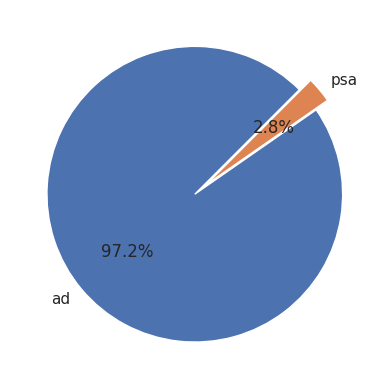

In [20]:
conversions = df[df.converted==True].groupby('test_group')['converted'].count()
plt.pie(conversions, labels=conversions.index, explode=[0,0.1], autopct='%1.1f%%', startangle=45)
plt.show()

## conclusions and recommendations
- the difference in their conversion rates are statistically significant.
- the ads are successful. as they brought in 97.2% of our conversions
- mondays saw the conversions. and peak hours are between 12pm - 11pm
- i suggest we run our most of our ads on mondays or tuesdays between these hours.